## This file achieves a style transfer use the pre-trained model VGG16

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13648374225999382639
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15715858185206818249
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8880881279773441189
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15856359834
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14744339391121810531
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [2]:
# Imports
import numpy as np
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [3]:
# parameters
nit = 10
channel = 3
Imsize=400
width = Imsize
height = Imsizes
RGB_me = [123.68, 116.779, 103.939]
content_weight = 0.02
style_weight = 3
var_weight = 0.9
var_loss = 1

In [4]:
# Paths
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"

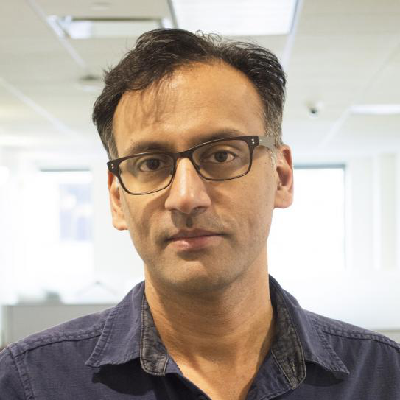

In [5]:
#Input visualization 
input_image = Image.open('professor.jpg')
input_image = input_image.resize((width, height))
input_image.save(input_image_path)
input_image

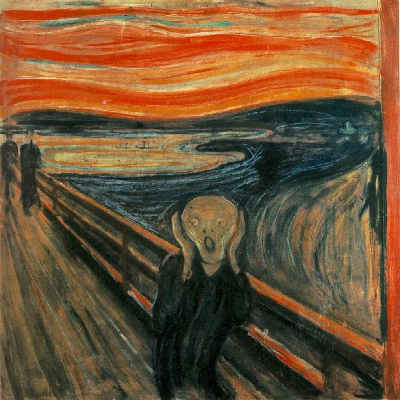

In [6]:
# Style visualization 
style_image = Image.open('Skrik.jpg')
style_image = style_image.resize((width, height))
style_image.save(style_image_path)
style_image

In [7]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= RGB_me[2]
input_image_array[:, :, :, 1] -= RGB_me[1]
input_image_array[:, :, :, 2] -= RGB_me[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= RGB_me[2]
style_image_array[:, :, :, 1] -= RGB_me[1]
style_image_array[:, :, :, 2] -= RGB_me[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [8]:
# Model
input_image = K.variable(input_image_array)
style_image = K.variable(style_image_array)
combination_image = K.placeholder((1, height, Imsize, 3))

input_tensor = K.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = K.variable(0.)
loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [10]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [11]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = height * width
    return K.sum(K.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * style_loss

In [12]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, val_loss))

loss += val_weight * total_variation_loss(combination_image)

In [13]:
outputs = [loss]
outputs += K.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, height, width,channels))
    outs = K.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 33225334784
Iteration 1 completed with loss 17818560512
Iteration 2 completed with loss 12777769984
Iteration 3 completed with loss 10257282048
Iteration 4 completed with loss 8984232960
Iteration 5 completed with loss 8234970112
Iteration 6 completed with loss 7726980608
Iteration 7 completed with loss 7391456256
Iteration 8 completed with loss 7183086592
Iteration 9 completed with loss 7036180992


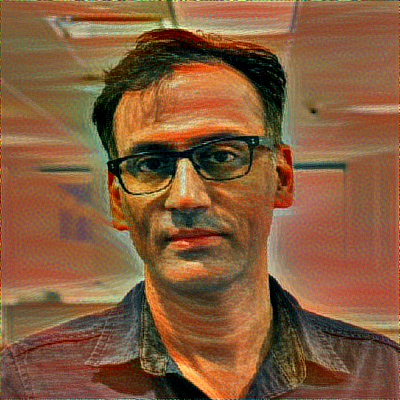

In [14]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

for i in range(nit):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((height, width, channel))
x = x[:, :, ::-1]
x[:, :, 0] += RGB_me[2]
x[:, :, 1] += RGB_me[1]
x[:, :, 2] += RGB_me[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image